In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import time

In [2]:
newdf_train=pd.read_csv("./data/train.csv",index_col=0)
for column in newdf_train.columns[:-1]:
    temp_column=newdf_train[column].to_numpy()
    temp_column=np.log(np.log(np.log(np.exp(temp_column)+1)+1)+1)
    newdf_train[column]=temp_column

In [5]:
newdf_train.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
id,,,,,,,,,,,,,,,,,,,,,
0,0.423036,0.423036,0.609036,0.423036,0.609036,0.423036,0.423036,0.423036,0.423036,0.423036,...,0.423036,0.423036,1.408800,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,Class_2
1,0.423036,0.423036,0.423036,0.423036,0.760830,0.609036,0.423036,0.423036,0.423036,0.423036,...,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,Class_1
2,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.760830,...,0.423036,0.609036,0.423036,0.423036,0.423036,0.423036,1.291725,0.760830,0.423036,Class_1
3,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.874789,0.423036,0.423036,...,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.609036,0.423036,Class_4
4,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,...,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.423036,0.609036,0.423036,Class_2


In [3]:
X=newdf_train[newdf_train.columns[:-1]].to_numpy()
y=newdf_train[newdf_train.columns[-1]].to_numpy().reshape(-1,1)

X_train,X_test,y_train,y_test=train_test_split(X,y,random_state=42,stratify=y)

In [4]:
def modelfit(alg, X_train, y_train, X_test, y_test, 
             useTrainCV=True, cv_folds=5, early_stopping_rounds=20):
    sm=SMOTE(random_state=42)
    X_train_smote,y_train_smote=sm.fit_resample(X_train,y_train)
    X_test_smote,y_test_smote=sm.fit_resample(X_test,y_test)
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgb_param['num_class'] = len(np.unique(X_train))
        xgtrain = xgb.DMatrix(X_train_smote, label=y_train_smote)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds, metrics='mlogloss', 
                          early_stopping_rounds=early_stopping_rounds)
        new_n_estimators=cvresult.shape[0]
        alg.set_params(n_estimators=new_n_estimators)
    
    #refit algo on full dataset
    alg.fit(X_train_smote, y_train_smote,eval_metric='mlogloss')
        
    dtrain_predprob = alg.predict_proba(X_train)
    dtrain_smote_predprob=alg.predict_proba(X_train_smote)
    dtest_predprob=alg.predict_proba(X_test)
    dtest_smote_predprob=alg.predict_proba(X_test_smote)
    #Print model report:
    print("\nModel Report")
    print("New n_estimators: {}".format(new_n_estimators))
    print("log loss (Train): %f" % log_loss(y_train, dtrain_predprob))
    print("log loss (Train SMOTE): %f" % log_loss(y_train_smote, dtrain_smote_predprob))
    print("log loss (Test): %f" % log_loss(y_test, dtest_predprob))
    print("log loss (Test SMOTE): %f" % log_loss(y_test_smote, dtest_smote_predprob))
    return cvresult

In [39]:
#finding optimal n_estimators with 0.1 learning rate
ordenc=OrdinalEncoder().fit(y_train)
y_train_ord=ordenc.transform(y_train)
y_test_ord=ordenc.transform(y_test)
predictors=newdf_train.columns[:-1]
xgb1=XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=6,
                  min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
                  objective="multi:softprob", seed=42,tree_method="gpu_hist",booster="gbtree")
cvresult=modelfit(xgb1, X_train, y_train_ord, X_test, y_test_ord)


Model Report
New n_estimators: 1000
log loss (Train): 0.740535
log loss (Train SMOTE): 0.623940
log loss (Test): 1.138817
log loss (Test SMOTE): 1.126269


In [5]:
#SMOTE significantly increased training time
plt.figure(figsize=(10,7))
plt.plot(range(len(cvresult["train-mlogloss-mean"])),cvresult["train-mlogloss-mean"].values,
        label="Train")
plt.plot(range(len(cvresult["test-mlogloss-mean"])),cvresult["test-mlogloss-mean"].values,
        label="Test")
plt.ylabel("logloss")

NameError: name 'cvresult' is not defined

<Figure size 720x504 with 0 Axes>

In [6]:

def pipe_smote_gridsearchcv(pipe,param_grid,X_train,y_train,X_test,y_test):
    grid=GridSearchCV(pipe,param_grid=param_grid,cv=4,scoring="neg_log_loss")
    grid.fit(X_train,y_train)
    print("Best params: {}".format(grid.best_params_))
    print("Best score (Train SMOTE): {}".format(grid.best_score_))
    print("Test score (Test SMOTE): {}".format(grid.score(X_test,y_test)))
    scaler=grid.best_estimator_.named_steps["scaler"]
    est=grid.best_estimator_.named_steps["classifier"]
    train_predictproba=est.predict_proba(scaler.transform(X_train))
    test_predictproba=est.predict_proba(scaler.transform(X_test))
    print("Train logloss (Train): {}".format(log_loss(y_train,train_predictproba)))
    print("Test logloss (Test): {}".format(log_loss(y_test,test_predictproba)))
    return grid

In [8]:
#looks like the more n_estimators the better but my computer is old
#so I have to cut down to decrease training time besides it looks like it's prone to overfitting
#finding max_depth and min_child_weight
pipe=Pipeline([("scaler",StandardScaler()),("SMOTE", SMOTE(random_state=42)),
               ("classifier",XGBClassifier())])
param_grid1={"classifier__learning_rate":[0.1],
             "classifier__n_estimators":[250],
             "classifier__max_depth":[4,6,8],
             "classifier__min_child_weight":[1,3,5],
             "classifier__gamma":[0],
             "classifier__subsample":[0.8],
             "classifier__colsample_bytree":[0.8],
             "classifier__objective":["multi:softprob"],
             "classifier__random_state":[42],
             "classifier__tree_method":["gpu_hist"],
             "classifier__booster":["gbtree"],
             "classifier__eval_metric":["mlogloss"]}
grid=pipe_smote_gridsearchcv(pipe,param_grid1,X_train,y_train,X_test,y_test)
grid.cv_results_

KeyboardInterrupt: 

In [12]:
pd.set_option("display.max_columns", 100)
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__booster,param_classifier__colsample_bytree,param_classifier__eval_metric,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__objective,param_classifier__random_state,param_classifier__subsample,param_classifier__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,13.385573,0.748931,0.183687,0.032834,gbtree,0.8,mlogloss,0,0.1,4,1,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101976,-1.105130,-1.102769,-1.099442,-1.102329,0.002031,1
1,12.576520,0.274528,0.177692,0.024501,gbtree,0.8,mlogloss,0,0.1,4,3,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102508,-1.105616,-1.102075,-1.099885,-1.102521,0.002045,3
2,12.319000,0.144631,0.156196,0.004325,gbtree,0.8,mlogloss,0,0.1,4,5,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102353,-1.105455,-1.102390,-1.099547,-1.102436,0.002090,2
3,18.111388,0.720206,0.203428,0.007259,gbtree,0.8,mlogloss,0,0.1,6,1,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.107873,-1.109726,-1.107696,-1.105344,-1.107660,0.001556,6
4,17.459125,0.542578,0.207425,0.010007,gbtree,0.8,mlogloss,0,0.1,6,3,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.108702,-1.109577,-1.106403,-1.104313,-1.107249,0.002054,5
5,17.724268,0.143219,0.213919,0.004526,gbtree,0.8,mlogloss,0,0.1,6,5,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.107057,-1.109837,-1.106586,-1.104019,-1.106875,0.002064,4
6,31.343284,0.372472,0.309149,0.013456,gbtree,0.8,mlogloss,0,0.1,8,1,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.120757,-1.119381,-1.117790,-1.114599,-1.118132,0.002294,9
7,28.360627,0.602937,0.269162,0.009007,gbtree,0.8,mlogloss,0,0.1,8,3,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.120763,-1.119898,-1.116679,-1.113733,-1.117769,0.002783,8
8,26.170027,0.144076,0.258410,0.002062,gbtree,0.8,mlogloss,0,0.1,8,5,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.119422,-1.119297,-1.115510,-1.114402,-1.117158,0.002237,7


In [11]:
#checking around max_depth=4 and min_child_weight=1
param_grid2={"classifier__learning_rate":[0.1],
             "classifier__n_estimators":[250],
             "classifier__max_depth":[3,4,5],
             "classifier__min_child_weight":[0,1,2],
             "classifier__gamma":[0],
             "classifier__subsample":[0.8],
             "classifier__colsample_bytree":[0.8],
             "classifier__objective":["multi:softprob"],
             "classifier__random_state":[42],
             "classifier__tree_method":["gpu_hist"],
             "classifier__booster":["gbtree"],
             "classifier__eval_metric":["mlogloss"]}
grid2=pipe_smote_gridsearchcv(pipe,param_grid2,X_train,y_train,X_test,y_test)


Best params: {'classifier__booster': 'gbtree', 'classifier__colsample_bytree': 0.8, 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 250, 'classifier__objective': 'multi:softprob', 'classifier__random_state': 42, 'classifier__subsample': 0.8, 'classifier__tree_method': 'gpu_hist'}
Best score (Train SMOTE): -1.1022726359942556
Test score (Test SMOTE): -1.098622963590622
Train logloss (Train): 1.0608920244656006
Test logloss (Test): 1.098622963590622


In [13]:
pd.DataFrame(grid2.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__booster,param_classifier__colsample_bytree,param_classifier__eval_metric,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__objective,param_classifier__random_state,param_classifier__subsample,param_classifier__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,11.801206,0.165972,0.146952,0.008857,gbtree,0.8,mlogloss,0,0.1,3,0,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.103036,-1.106568,-1.104330,-1.101328,-1.103816,0.001913,7
1,11.640979,0.337246,0.144203,0.009650,gbtree,0.8,mlogloss,0,0.1,3,1,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.103269,-1.106419,-1.104283,-1.101030,-1.103750,0.001939,5
2,11.790610,0.332160,0.138705,0.001299,gbtree,0.8,mlogloss,0,0.1,3,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.103140,-1.106445,-1.104229,-1.100713,-1.103632,0.002064,4
3,12.126761,0.230563,0.157187,0.006143,gbtree,0.8,mlogloss,0,0.1,4,0,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102244,-1.105072,-1.102455,-1.099490,-1.102315,0.001975,2
4,12.865850,0.153861,0.162947,0.009946,gbtree,0.8,mlogloss,0,0.1,4,1,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101976,-1.105130,-1.102769,-1.099442,-1.102329,0.002031,3
5,13.072333,0.275612,0.171183,0.006096,gbtree,0.8,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102055,-1.105256,-1.102256,-1.099524,-1.102273,0.002031,1
6,14.979958,0.205251,0.179927,0.007581,gbtree,0.8,mlogloss,0,0.1,5,0,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.104678,-1.107031,-1.103863,-1.100296,-1.103967,0.002417,8
7,14.846583,0.155381,0.184182,0.002578,gbtree,0.8,mlogloss,0,0.1,5,1,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.104230,-1.106829,-1.104070,-1.100106,-1.103809,0.002402,6
8,14.620282,0.271522,0.191188,0.015590,gbtree,0.8,mlogloss,0,0.1,5,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.104559,-1.107335,-1.104133,-1.100418,-1.104111,0.002461,9


In [22]:
#best max_depth=4 and min_child_weight=2
#finding gamma
param_grid3={"classifier__learning_rate":[0.1],
             "classifier__n_estimators":[250],
             "classifier__max_depth":[4],
             "classifier__min_child_weight":[2],
             "classifier__gamma":[0,0.1,0.2,0.3,0.5,0.7,0.9],
             "classifier__subsample":[0.8],
             "classifier__colsample_bytree":[0.8],
             "classifier__objective":["multi:softprob"],
             "classifier__random_state":[42],
             "classifier__tree_method":["gpu_hist"],
             "classifier__booster":["gbtree"],
             "classifier__eval_metric":["mlogloss"]}
grid3=pipe_smote_gridsearchcv(pipe,param_grid3,X_train,y_train,X_test,y_test)

Best params: {'classifier__booster': 'gbtree', 'classifier__colsample_bytree': 0.8, 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 250, 'classifier__objective': 'multi:softprob', 'classifier__random_state': 42, 'classifier__subsample': 0.8, 'classifier__tree_method': 'gpu_hist'}
Best score (Train SMOTE): -1.1022726359942556
Test score (Test SMOTE): -1.098622963590622
Train logloss (Train): 1.0608920244656006
Test logloss (Test): 1.098622963590622


In [23]:
pd.DataFrame(grid3.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__booster,param_classifier__colsample_bytree,param_classifier__eval_metric,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__objective,param_classifier__random_state,param_classifier__subsample,param_classifier__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,13.450113,0.081253,0.177192,0.016838,gbtree,0.8,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102055,-1.105256,-1.102256,-1.099524,-1.102273,0.002031,1
1,12.886141,0.128283,0.162697,0.001298,gbtree,0.8,mlogloss,0.1,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102046,-1.105366,-1.102328,-1.099437,-1.102294,0.002101,2
2,12.874540,0.117230,0.164696,0.002585,gbtree,0.8,mlogloss,0.2,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101866,-1.105579,-1.102466,-1.099380,-1.102323,0.002207,3
3,12.911158,0.110179,0.158948,0.007174,gbtree,0.8,mlogloss,0.3,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102582,-1.105406,-1.102225,-1.099635,-1.102462,0.002045,6
4,12.887912,0.129476,0.162947,0.001871,gbtree,0.8,mlogloss,0.5,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102253,-1.105284,-1.102369,-1.099641,-1.102387,0.001997,5
5,12.950054,0.199250,0.162697,0.003191,gbtree,0.8,mlogloss,0.7,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102263,-1.105692,-1.102193,-1.099810,-1.102490,0.002096,7
6,12.904163,0.113288,0.159194,0.006052,gbtree,0.8,mlogloss,0.9,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102016,-1.105438,-1.102278,-1.099771,-1.102376,0.002019,4


In [24]:
#best gamma=0
param_grid4={"classifier__learning_rate":[0.1],
             "classifier__n_estimators":[250],
             "classifier__max_depth":[4],
             "classifier__min_child_weight":[2],
             "classifier__gamma":[0],
             "classifier__subsample":[0.6,0.7,0.8,0.9],
             "classifier__colsample_bytree":[0.6,0.7,0.8,0.9],
             "classifier__objective":["multi:softprob"],
             "classifier__random_state":[42],
             "classifier__tree_method":["gpu_hist"],
             "classifier__booster":["gbtree"],
             "classifier__eval_metric":["mlogloss"]}
grid4=pipe_smote_gridsearchcv(pipe,param_grid4,X_train,y_train,X_test,y_test)

Best params: {'classifier__booster': 'gbtree', 'classifier__colsample_bytree': 0.6, 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 250, 'classifier__objective': 'multi:softprob', 'classifier__random_state': 42, 'classifier__subsample': 0.7, 'classifier__tree_method': 'gpu_hist'}
Best score (Train SMOTE): -1.101574809829394
Test score (Test SMOTE): -1.098478347530961
Train logloss (Train): 1.0624740972808004
Test logloss (Test): 1.098478347530961


In [25]:
pd.DataFrame(grid4.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__booster,param_classifier__colsample_bytree,param_classifier__eval_metric,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__objective,param_classifier__random_state,param_classifier__subsample,param_classifier__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,12.398376,0.249266,0.161947,0.001414,gbtree,0.6,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.6,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101927,-1.105454,-1.102111,-1.098460,-1.101988,0.002474,4
1,12.563323,0.133735,0.162697,0.002585,gbtree,0.6,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.7,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101036,-1.104235,-1.102296,-1.098732,-1.101575,0.001998,1
2,12.760854,0.116870,0.157948,0.005786,gbtree,0.6,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101560,-1.105028,-1.101733,-1.099192,-1.101878,0.002077,3
3,12.947192,0.125517,0.159197,0.006416,gbtree,0.6,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.9,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101599,-1.104217,-1.101946,-1.099259,-1.101755,0.001757,2
4,12.250566,0.126985,0.161197,0.001479,gbtree,0.7,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.6,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102105,-1.105394,-1.101618,-1.099203,-1.102080,0.002207,5
5,12.502949,0.368539,0.174943,0.030763,gbtree,0.7,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.7,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102253,-1.105544,-1.101816,-1.098909,-1.102131,0.002353,8
6,12.714876,0.245046,0.162697,0.015282,gbtree,0.7,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.8,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102193,-1.105130,-1.101982,-1.099186,-1.102123,0.002103,7
7,12.465002,0.360292,0.157445,0.014737,gbtree,0.7,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.9,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102042,-1.104578,-1.102018,-1.099685,-1.102081,0.001731,6
8,12.122207,0.320221,0.166696,0.023277,gbtree,0.8,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.6,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102275,-1.105272,-1.102405,-1.098801,-1.102188,0.002293,9
9,12.271694,0.248627,0.162447,0.007397,gbtree,0.8,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.7,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102530,-1.105203,-1.102360,-1.098822,-1.102229,0.002267,10


In [26]:
#checking around subsample=0.7 and colsample_bytree=0.6
param_grid5={"classifier__learning_rate":[0.1],
             "classifier__n_estimators":[250],
             "classifier__max_depth":[4],
             "classifier__min_child_weight":[2],
             "classifier__gamma":[0],
             "classifier__subsample":[0.65,0.7,0.75],
             "classifier__colsample_bytree":[0.55,0.6,0.65],
             "classifier__objective":["multi:softprob"],
             "classifier__random_state":[42],
             "classifier__tree_method":["gpu_hist"],
             "classifier__booster":["gbtree"],
             "classifier__eval_metric":["mlogloss"]}
grid5=pipe_smote_gridsearchcv(pipe,param_grid5,X_train,y_train,X_test,y_test)

Best params: {'classifier__booster': 'gbtree', 'classifier__colsample_bytree': 0.55, 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 250, 'classifier__objective': 'multi:softprob', 'classifier__random_state': 42, 'classifier__subsample': 0.75, 'classifier__tree_method': 'gpu_hist'}
Best score (Train SMOTE): -1.1014642712062597
Test score (Test SMOTE): -1.097393063197136
Train logloss (Train): 1.0630465105886757
Test logloss (Test): 1.097393063197136


In [27]:
pd.DataFrame(grid5.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__booster,param_classifier__colsample_bytree,param_classifier__eval_metric,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__objective,param_classifier__random_state,param_classifier__subsample,param_classifier__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,11.963247,0.397177,0.176938,0.024720,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.65,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101372,-1.104706,-1.101423,-1.098414,-1.101479,0.002226,2
1,12.388786,0.672301,0.188938,0.037941,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.7,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101909,-1.103946,-1.101746,-1.098543,-1.101536,0.001933,3
2,13.005736,0.519488,0.177946,0.006514,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101610,-1.104739,-1.101589,-1.097919,-1.101464,0.002415,1
3,12.676173,0.439034,0.179691,0.018801,gbtree,0.6,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.65,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101364,-1.105089,-1.102075,-1.098987,-1.101879,0.002178,5
4,12.165131,0.278108,0.161688,0.008848,gbtree,0.6,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.7,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101036,-1.104235,-1.102296,-1.098732,-1.101575,0.001998,4
5,12.176055,0.175738,0.158448,0.007363,gbtree,0.6,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.102059,-1.105315,-1.101456,-1.098775,-1.101901,0.002326,6
6,11.600992,0.150022,0.153700,0.001298,gbtree,0.65,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.65,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101988,-1.104916,-1.102397,-1.099081,-1.102096,0.002070,8
7,11.712705,0.159724,0.153700,0.004204,gbtree,0.65,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.7,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101293,-1.106006,-1.102275,-1.098708,-1.102071,0.002619,7
8,12.030103,0.479280,0.156199,0.009173,gbtree,0.65,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101817,-1.105095,-1.102453,-1.099153,-1.102130,0.002113,9


In [28]:
#checking even lower values for colsample_bytree
param_grid55={"classifier__learning_rate":[0.1],
             "classifier__n_estimators":[250],
             "classifier__max_depth":[4],
             "classifier__min_child_weight":[2],
             "classifier__gamma":[0],
             "classifier__subsample":[0.75],
             "classifier__colsample_bytree":[0.45,0.5,0.55],
             "classifier__objective":["multi:softprob"],
             "classifier__random_state":[42],
             "classifier__tree_method":["gpu_hist"],
             "classifier__booster":["gbtree"],
             "classifier__eval_metric":["mlogloss"]}
grid55=pipe_smote_gridsearchcv(pipe,param_grid55,X_train,y_train,X_test,y_test)

Best params: {'classifier__booster': 'gbtree', 'classifier__colsample_bytree': 0.5, 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 250, 'classifier__objective': 'multi:softprob', 'classifier__random_state': 42, 'classifier__subsample': 0.75, 'classifier__tree_method': 'gpu_hist'}
Best score (Train SMOTE): -1.1013222855420908
Test score (Test SMOTE): -1.0980036335384846
Train logloss (Train): 1.0637846160143614
Test logloss (Test): 1.0980036335384846


In [29]:
pd.DataFrame(grid55.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__booster,param_classifier__colsample_bytree,param_classifier__eval_metric,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__objective,param_classifier__random_state,param_classifier__subsample,param_classifier__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,12.807592,0.302397,0.171439,0.020163,gbtree,0.45,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101490,-1.104167,-1.101067,-1.098658,-1.101346,0.001955,2
1,12.605982,0.128653,0.161192,0.007460,gbtree,0.5,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101503,-1.104458,-1.101625,-1.097703,-1.101322,0.002401,1
2,12.584693,0.103512,0.159943,0.005517,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101610,-1.104739,-1.101589,-1.097919,-1.101464,0.002415,3


In [30]:
#best subsample=0.75 and colsample_bytree=0.5 but on test set better colsample_bytree=0.55
#finging reg_alpha and reg_lambda
param_grid6={"classifier__learning_rate":[0.1],
             "classifier__n_estimators":[250],
             "classifier__max_depth":[4],
             "classifier__min_child_weight":[2],
             "classifier__gamma":[0],
             "classifier__subsample":[0.75],
             "classifier__colsample_bytree":[0.55],
             "classifier__reg_alpha":[0,1e-5,0.01,0.1,1,10],
             "classifier__reg_lambda":[0,0.01,0.1,1,10],
             "classifier__objective":["multi:softprob"],
             "classifier__random_state":[42],
             "classifier__tree_method":["gpu_hist"],
             "classifier__booster":["gbtree"],
             "classifier__eval_metric":["mlogloss"]}
grid6=pipe_smote_gridsearchcv(pipe,param_grid6,X_train,y_train,X_test,y_test)

Best params: {'classifier__booster': 'gbtree', 'classifier__colsample_bytree': 0.55, 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 250, 'classifier__objective': 'multi:softprob', 'classifier__random_state': 42, 'classifier__reg_alpha': 10, 'classifier__reg_lambda': 10, 'classifier__subsample': 0.75, 'classifier__tree_method': 'gpu_hist'}
Best score (Train SMOTE): -1.1001997400776546
Test score (Test SMOTE): -1.097737533749342
Train logloss (Train): 1.0725094157181183
Test logloss (Test): 1.097737533749342


In [31]:
pd.DataFrame(grid6.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__booster,param_classifier__colsample_bytree,param_classifier__eval_metric,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__objective,param_classifier__random_state,param_classifier__reg_alpha,param_classifier__reg_lambda,param_classifier__subsample,param_classifier__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,12.278624,0.360688,0.155190,0.005799,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,0,0,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101046,-1.104136,-1.101780,-1.098368,-1.101333,0.002057,18
1,12.014040,0.509999,0.160938,0.015699,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,0,0.01,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100873,-1.104091,-1.102050,-1.098571,-1.101396,0.001997,22
2,11.478095,0.124171,0.148452,0.000866,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,0,0.1,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101621,-1.103987,-1.102012,-1.098190,-1.101453,0.002086,23
3,11.450050,0.112668,0.153195,0.001293,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,0,1,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101610,-1.104739,-1.101589,-1.097919,-1.101464,0.002415,24
4,11.458075,0.157135,0.149446,0.001662,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,0,10,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100580,-1.104177,-1.101540,-1.097669,-1.100991,0.002327,8
5,11.504953,0.139113,0.148939,0.000709,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,1e-05,0,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100913,-1.104156,-1.101779,-1.098368,-1.101304,0.002069,16
6,11.488075,0.134385,0.150193,0.002270,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,1e-05,0.01,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100873,-1.104090,-1.102050,-1.098520,-1.101383,0.002014,21
7,11.479879,0.137480,0.150193,0.001299,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,1e-05,0.1,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101623,-1.103987,-1.102022,-1.098422,-1.101513,0.001996,27
8,11.445717,0.105562,0.149445,0.000862,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,1e-05,1,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.101406,-1.104594,-1.101589,-1.097919,-1.101377,0.002364,20
9,11.447605,0.129337,0.150451,0.002290,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,1e-05,10,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100579,-1.104177,-1.101540,-1.097669,-1.100991,0.002327,7


In [32]:
#checking around alpha=10 and lambda=10
param_grid7={"classifier__learning_rate":[0.1],
             "classifier__n_estimators":[250],
             "classifier__max_depth":[4],
             "classifier__min_child_weight":[2],
             "classifier__gamma":[0],
             "classifier__subsample":[0.75],
             "classifier__colsample_bytree":[0.55],
             "classifier__reg_alpha":[8,10,15,30,100],
             "classifier__reg_lambda":[5,8,10,15,30,100],
             "classifier__objective":["multi:softprob"],
             "classifier__random_state":[42],
             "classifier__tree_method":["gpu_hist"],
             "classifier__booster":["gbtree"],
             "classifier__eval_metric":["mlogloss"]}
grid7=pipe_smote_gridsearchcv(pipe,param_grid7,X_train,y_train,X_test,y_test)

Best params: {'classifier__booster': 'gbtree', 'classifier__colsample_bytree': 0.55, 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 250, 'classifier__objective': 'multi:softprob', 'classifier__random_state': 42, 'classifier__reg_alpha': 15, 'classifier__reg_lambda': 10, 'classifier__subsample': 0.75, 'classifier__tree_method': 'gpu_hist'}
Best score (Train SMOTE): -1.0998426176375151
Test score (Test SMOTE): -1.097658251903653
Train logloss (Train): 1.0749073590741556
Test logloss (Test): 1.097658251903653


In [33]:
pd.DataFrame(grid7.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__booster,param_classifier__colsample_bytree,param_classifier__eval_metric,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__objective,param_classifier__random_state,param_classifier__reg_alpha,param_classifier__reg_lambda,param_classifier__subsample,param_classifier__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,13.291557,0.580178,0.160944,0.003670,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,8,5,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100599,-1.103105,-1.101218,-1.097466,-1.100597,0.002030,22
1,13.425400,0.839625,0.168940,0.016545,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,8,8,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100949,-1.102869,-1.100631,-1.097338,-1.100447,0.001989,18
2,12.162161,0.290983,0.161193,0.019040,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,8,10,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100283,-1.103248,-1.100843,-1.097364,-1.100435,0.002094,17
3,12.409952,0.193932,0.181940,0.018675,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,8,15,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100712,-1.103026,-1.101160,-1.097128,-1.100507,0.002135,20
4,12.609166,0.730352,0.182940,0.023100,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,8,30,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100169,-1.102854,-1.100973,-1.097084,-1.100270,0.002082,13
5,12.140170,0.395914,0.150697,0.003112,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,8,100,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100139,-1.103270,-1.101001,-1.097207,-1.100404,0.002171,16
6,12.154323,0.199582,0.171684,0.021275,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,10,5,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100635,-1.102983,-1.101306,-1.097323,-1.100562,0.002056,21
7,12.416835,0.251990,0.159448,0.010159,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,10,8,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100570,-1.102593,-1.100744,-1.097055,-1.100241,0.002003,12
8,11.741201,0.199662,0.155694,0.006836,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,10,10,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100536,-1.102621,-1.100570,-1.097072,-1.100200,0.001993,10
9,12.192915,0.642988,0.157698,0.008434,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,10,15,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100286,-1.102923,-1.100902,-1.096668,-1.100195,0.002258,9


In [34]:
#checking around alpha=15 and lambda=10
param_grid8={"classifier__learning_rate":[0.1],
             "classifier__n_estimators":[250],
             "classifier__max_depth":[4],
             "classifier__min_child_weight":[2],
             "classifier__gamma":[0],
             "classifier__subsample":[0.75],
             "classifier__colsample_bytree":[0.55],
             "classifier__reg_alpha":[14,15,16],
             "classifier__reg_lambda":[9,10,11],
             "classifier__objective":["multi:softprob"],
             "classifier__random_state":[42],
             "classifier__tree_method":["gpu_hist"],
             "classifier__booster":["gbtree"],
             "classifier__eval_metric":["mlogloss"]}
grid8=pipe_smote_gridsearchcv(pipe,param_grid8,X_train,y_train,X_test,y_test)

Best params: {'classifier__booster': 'gbtree', 'classifier__colsample_bytree': 0.55, 'classifier__eval_metric': 'mlogloss', 'classifier__gamma': 0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 4, 'classifier__min_child_weight': 2, 'classifier__n_estimators': 250, 'classifier__objective': 'multi:softprob', 'classifier__random_state': 42, 'classifier__reg_alpha': 15, 'classifier__reg_lambda': 10, 'classifier__subsample': 0.75, 'classifier__tree_method': 'gpu_hist'}
Best score (Train SMOTE): -1.0998426176375151
Test score (Test SMOTE): -1.097658251903653
Train logloss (Train): 1.0749073590741556
Test logloss (Test): 1.097658251903653


In [35]:
pd.DataFrame(grid8.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__booster,param_classifier__colsample_bytree,param_classifier__eval_metric,param_classifier__gamma,param_classifier__learning_rate,param_classifier__max_depth,param_classifier__min_child_weight,param_classifier__n_estimators,param_classifier__objective,param_classifier__random_state,param_classifier__reg_alpha,param_classifier__reg_lambda,param_classifier__subsample,param_classifier__tree_method,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
0,13.104482,0.398877,0.166446,0.007431,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,14,9,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100136,-1.102875,-1.100640,-1.096911,-1.100140,0.002131,6
1,12.777205,0.153189,0.160692,0.005353,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,14,10,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.099936,-1.102618,-1.100687,-1.097008,-1.100062,0.002017,3
2,12.645105,0.131761,0.160948,0.007139,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,14,11,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100061,-1.102513,-1.100970,-1.096772,-1.100079,0.002101,4
3,12.160818,0.430285,0.157444,0.007433,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,15,9,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100478,-1.102664,-1.100252,-1.097154,-1.100137,0.001963,5
4,12.600712,0.601025,0.164945,0.009483,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,15,10,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.099950,-1.102429,-1.100305,-1.096687,-1.099843,0.002054,1
5,12.795393,0.221361,0.173194,0.016063,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,15,11,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100433,-1.102539,-1.100402,-1.097216,-1.100147,0.001901,7
6,12.662563,0.109788,0.160447,0.006575,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,16,9,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100013,-1.102743,-1.100678,-1.096686,-1.100030,0.002177,2
7,12.627249,0.149661,0.164446,0.004270,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,16,10,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100184,-1.102704,-1.100870,-1.096915,-1.100168,0.002092,8
8,12.286860,0.358506,0.156944,0.006166,gbtree,0.55,mlogloss,0,0.1,4,2,250,multi:softprob,42,16,11,0.75,gpu_hist,"{'classifier__booster': 'gbtree', 'classifier_...",-1.100333,-1.102844,-1.100844,-1.097173,-1.100298,0.002034,9


In [36]:
#best alpha=15 and lambda=10
#decreasing learning rate and increasing boosting rounds
ordenc=OrdinalEncoder().fit(y_train)
y_train_ord=ordenc.transform(y_train)
y_test_ord=ordenc.transform(y_test)
predictors=newdf_train.columns[:-1]
xgb2=XGBClassifier(learning_rate=0.03, n_estimators=5000, max_depth=4,
                  min_child_weight=2, gamma=0, subsample=0.75, colsample_bytree=0.55,
                  reg_alpha=15,reg_lambda=10,
                  objective="multi:softprob", random_state=42,tree_method="gpu_hist",booster="gbtree")
cvresult_2=modelfit(xgb2, X_train, y_train_ord, X_test, y_test_ord)


Model Report
New n_estimators: 5000
log loss (Train): 1.001395
log loss (Train SMOTE): 0.903774
log loss (Test): 1.106756
log loss (Test SMOTE): 1.091902


In [37]:
cvresult_2

,train-mlogloss-mean,train-mlogloss-std,test-mlogloss-mean,test-mlogloss-std
0,3.983853,0.000231,3.984070,0.000345
1,3.768595,0.001353,3.769022,0.001683
2,3.593656,0.000864,3.594413,0.000682
3,3.448994,0.000803,3.449871,0.000761
4,3.323844,0.001350,3.324790,0.000298
...,...,...,...,...
4995,0.901331,0.000502,0.975252,0.002187
4996,0.901307,0.000503,0.975237,0.002185
4997,0.901284,0.000503,0.975225,0.002184
4998,0.901263,0.000504,0.975213,0.002183


Text(0, 0.5, 'logloss')

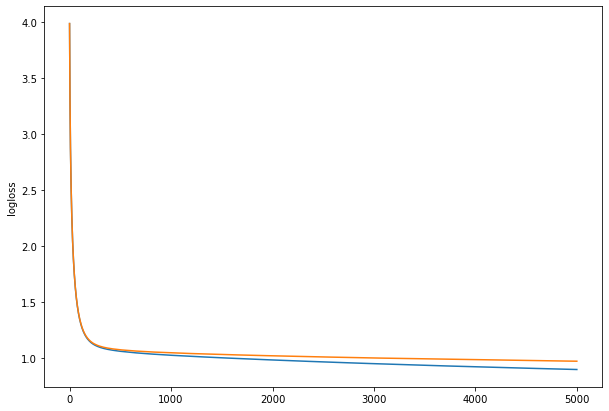

In [38]:
plt.figure(figsize=(10,7))
plt.plot(range(len(cvresult_2["train-mlogloss-mean"])),cvresult_2["train-mlogloss-mean"].values,
        label="Train")
plt.plot(range(len(cvresult_2["test-mlogloss-mean"])),cvresult_2["test-mlogloss-mean"].values,
        label="Test")
plt.ylabel("logloss")

In [41]:
xgb_fin=XGBClassifier(learning_rate=0.05, n_estimators=3000, max_depth=4,
                  min_child_weight=2, gamma=0, subsample=0.75, colsample_bytree=0.55,
                  reg_alpha=15,reg_lambda=10,eval_metric="mlogloss",
                  objective="multi:softprob", random_state=42,tree_method="gpu_hist",booster="gbtree",
                     )
pipe_fin=Pipeline([("scaler",StandardScaler()),("SMOTE", SMOTE(random_state=42)),
               ("classifier",xgb_fin)])
pipe_fin.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()), ('SMOTE', SMOTE(random_state=42)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=0.55, eval_metric='mlogloss',
                               gamma=0, gpu_id=0, importance_type='gain',
                               interaction_constraints='', learning_rate=0.05,
                               max_delta_step=0, max_depth=4,
                               min_child_weight=2, missing=nan,
                               monotone_constraints='()', n_estimators=3000,
                               n_jobs=4, num_parallel_tree=1,
                               objective='multi:softprob', random_state=42,
                               reg_alpha=15, reg_lambda=10,
                               scale_pos_weight=None, subsample=0.75,
                               tree_method='gpu_h

In [42]:
print("logloss : {}".format(log_loss(y,pipe_fin.predict_proba(X))))

logloss : 1.0175424924348295
